<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/DEAP_KappaMu_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorithms: $\kappa$-$\mu$ fading distribution parameter estimation using deap.


In [2]:
# !pip install deap

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
import deap
from deap import algorithms, base, creator, tools
from KappaMu import KappaMu

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

def evaluation(theta):
  X = np.array([1,2,3,4,5,20,26,7])
  Y = np.array([5,7,9,11,13,43,55,17])

  n = len(X)
  y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

def computePDF(r, kappa, mu, r_hat):
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  R = r / r_hat
  B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  PDF = A * B * C / r_hat 
  return PDF

def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = ku.X
  Y = ku.Y
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [4]:
ku = KappaMu(kappa=1, mu=4, r_hat=1, numSamples=100, numSim=10**6)

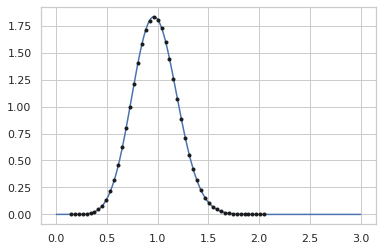

In [5]:
r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
plt.plot(r, ku._pdf(r))
plt.plot(ku.X[1:len(ku.X):2], ku.Y[1:len(ku.Y):2], "k.", label='Simulation')

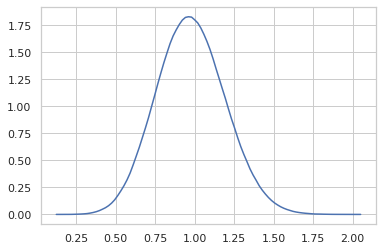

In [6]:
plt.plot(ku.X,ku.Y)

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for each $\hat{\theta}_i$


In [9]:
toolbox = base.Toolbox()

In [10]:
toolbox.register("attr_bool", np.random.uniform, 0.1, 5)
toolbox.attr_bool()

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.individual()

[1.8779758388354448, 3.5187172541299145, 2.752193494140645]

In [11]:
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [12]:
pop = toolbox.population(n=500)

In [13]:
hof = tools.ParetoFront()

In [14]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [15]:
# sortedPop = sorted(pop, key=lambda ind:ind.fitness)

In [16]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,\
                               ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std     	min        	max    
0  	500   	0.79668	0.741037	0.000214616	6.00749
1  	306   	0.526277	0.376077	0.00139627 	7.04795
2  	298   	0.3497  	0.219791	0.00131799 	1.66878
3  	299   	0.189892	0.202441	0.000164283	1.8545 
4  	316   	0.076841	0.0976451	0.000164283	0.679661
5  	298   	0.041993	0.0831531	0.000164283	0.68005 
6  	314   	0.0384078	0.0970543	6.11255e-05	0.693761
7  	275   	0.0224712	0.109464 	5.81433e-05	2.04658 
8  	291   	0.0221497	0.0835998	1.91026e-05	0.822072
9  	316   	0.0196029	0.0770205	3.72269e-05	0.699009
10 	289   	0.00886922	0.0500589	3.72269e-05	0.631356
11 	290   	0.00290197	0.0315056	3.72269e-05	0.693761
12 	303   	0.00768962	0.066761 	3.72269e-05	0.693761
13 	308   	0.0147436 	0.0931582	3.72269e-05	0.694444
14 	310   	0.0219272 	0.115447 	3.72269e-05	0.694444
15 	288   	0.0162654 	0.0973602	3.72269e-05	0.694444
16 	307   	0.0148254 	0.0898563	3.72269e-05	0.771721
17 	320   	0.013572  	0.0879138	3.72269e-05	0.771721
18 	296   	0.0102098 	0

In [17]:
print('Current best fitness:', fitnessFunction(tools.selBest(pop, k=1)[0]))

Current best fitness: (3.722692903196067e-05,)


In [40]:
hof[0]

[1.0786237531683807, 3.8839831994399745, 1.0007497493372124]

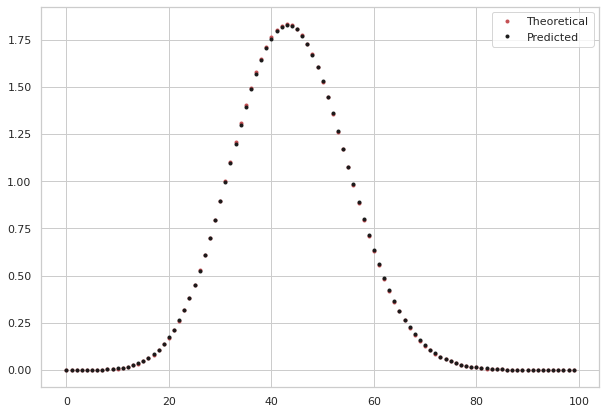

In [41]:
theta = [1,4,1]
kappa = theta[0]
mu = theta[1]
r_hat = theta[2]
X = ku.X
Y = ku.Y
y_pred = computePDF(X, kappa, mu, r_hat)

plt.figure(figsize=(10,7))
plt.plot(y_pred,'.r', label='Theoretical')
plt.plot(computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.legend()
plt.show()

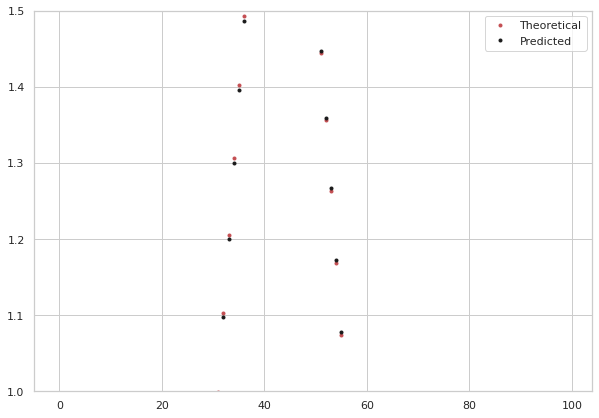

In [43]:
plt.figure(figsize=(10,7))
plt.plot(y_pred,'.r', label='Theoretical')
plt.plot(computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.ylim((1,1.5))
plt.legend()
plt.show()

### True function:

$y=2x+3$

$⇒\theta_0=2$

$⇒\theta_1=3$

In [19]:
len(hof)

1

In [20]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))

$\theta_0$ is 1.0786237531683807, $\theta_1$ is 3.8839831994399745 and $\theta_1$ is 1.0007497493372124.


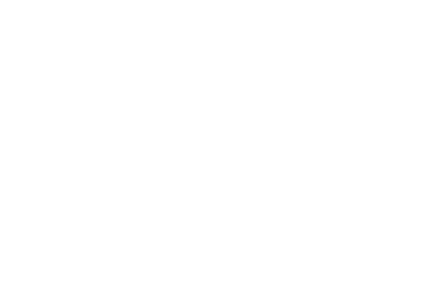

In [21]:
import matplotlib.pyplot as plt
import networkx

history = tools.History()
graph = networkx.DiGraph(history.genealogy_tree)
graph = graph.reverse()     # Make the graph top-down
colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
networkx.draw(graph, node_color=colors)
plt.show()

In [22]:
# record = stats.compile(pop)
# logbook = tools.Logbook()
# logbook.record(gen=0, evals=30, **record)

In [23]:
# gen = log.select("gen")
# fit_mins = log.select("min")
# size_avgs = log.select("avg")

In [24]:
# gen, avg = logbook.select("gen", "avg")

In [25]:
# logbook.header = "gen", "avg", "spam"

In [26]:
# print(logbook)

In [27]:
# gen = logbook.select("gen")
# fit_mins = logbook.chapters["fitness"].select("min")
# size_avgs = logbook.chapters["size"].select("avg")

# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots()
# line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
# ax1.set_xlabel("Generation")
# ax1.set_ylabel("Fitness", color="b")
# for tl in ax1.get_yticklabels():
#     tl.set_color("b")

# ax2 = ax1.twinx()
# line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
# ax2.set_ylabel("Size", color="r")
# for tl in ax2.get_yticklabels():
#     tl.set_color("r")

# lns = line1 + line2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="center right")

# plt.show()

In [28]:
# gen = logbook.select("gen")
# fit_mins = logbook.select("min")
# size_avgs = logbook.select("avg")


In [29]:
# plt.figure(figsize=(10,7))
# plt.plot(gen, size_avgs, "r-", label="Average Fitness")
# plt.xlabel('Generation')
# plt.ylabel('Average Fitness')
# plt.show()

In [30]:
# plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
# plt.xlabel('Generation')
# plt.ylabel('Minimum Fitness')
# plt.show()

In [31]:
fit_mins

NameError: ignored